In [61]:
%pip install shapely

Note: you may need to restart the kernel to use updated packages.


## Creacion de mapa

Queremos crear un mapa que represente cierta informacion sobre cada comuna en el territorio de chile.

In [62]:
import pandas as pd
import geopandas as gpd
import re
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [63]:
import pandas as pd

# Ruta al archivo CSV
file_path = './Informe Noches Cama 2022final.csv'

# Cargamos el archivo CSV
df = pd.read_csv(file_path, encoding='ISO-8859-1', delimiter=';', header=2)

# Agrupamos por 'Destino' y obtenemos los valores únicos de las columnas específicas
unique_values_df = df.groupby('Destino').agg(lambda x: x.unique().tolist())

# Mostramos los resultados
unique_values = unique_values_df[['VTE', 'TF', 'GE', 'TOTAL', 'X', 'Y']]

# For every column in the dataframe, delete the "[]" delimiters of each cell
for column in unique_values:
    unique_values[column] = unique_values[column].str[0]

unique_values.to_csv('turismo_social.csv', index=False)

display(unique_values)


C:\Users\n3mes\AppData\Local\Temp\ipykernel_28640\2988531571.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_values[column] = unique_values[column].str[0]


,VTE,TF,GE,TOTAL,X,Y
Destino,,,,,,
ARICA,3044,69,240,3353,"70° 19' 6,967"" W","18° 28' 47,942"" S"
Alto del Carmen,537,0,0,537,"70° 29' 11,636"" W","28° 45' 35,216"" S"
Ancud,1889,0,354,2243,"73° 49' 41,867"" W","41° 52' 5,614"" S"
Antuco,765,343,0,1108,"71° 40' 47,950"" W","37° 19' 48,104"" S"
Antuco,765,343,0,1108,"71° 40' 47,950"" W","37° 19' 48,104"" S"
...,...,...,...,...,...,...
Valle Las Trancas,972,0,0,972,"71°29' 37,000"" W","36°54' 44,000"" S"
Vichuquen,641,308,0,949,"71° 59' 33,306"" W","34° 53' 3,358"" S"
Vicuña - Valle del Elqui,524,375,0,899,"70° 42' 48,855"" W","30° 2' 0,567"" S"


C:\Users\n3mes\AppData\Local\Temp\ipykernel_28640\247084260.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_values['X_decimal'] = unique_values['X'].apply(safe_dms2dec)
C:\Users\n3mes\AppData\Local\Temp\ipykernel_28640\247084260.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_values['Y_decimal'] = unique_values['Y'].apply(safe_dms2dec)
C:\Users\n3mes\AppData\Local\Temp\ipykernel_28640\247084260.py:45: FutureWarning: The geopandas.dataset module is deprecated and will be removed in Ge

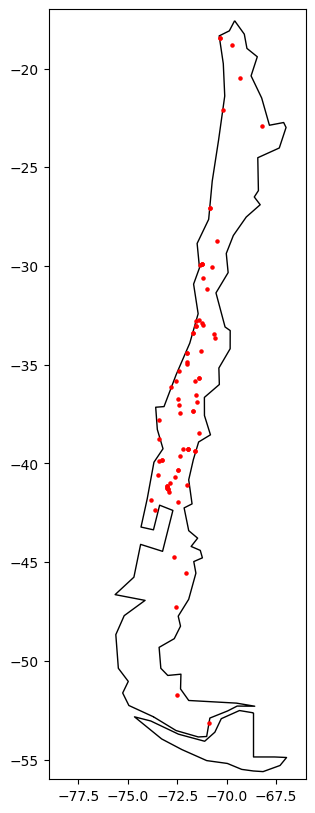

In [64]:
# funciones para convertir las coordenadas DMS a decimal

def dms2dec(dms_str):
    """Convierte una cadena de coordenadas DMS (grados, minutos, segundos) a coordenadas decimales."""
    dms_str = re.sub(r'\s', '', dms_str)
    dms_str = re.sub(r'°', ' ', dms_str)
    dms_str = re.sub(r'\'', ' ', dms_str)
    dms_str = re.sub(r'\"', ' ', dms_str)
    parts = dms_str.split()

    d = float(parts[0])
    m = float(parts[1].replace(',', '.'))
    s = float(parts[2].replace(',', '.'))

    dd = d + m/60 + s/3600
    return dd

def safe_dms2dec(dms_str):
    if pd.notna(dms_str):
        try:
            return -dms2dec(dms_str)
        except:
            return None
    return None


# Convertimos las coordenadas DMS a decimal
unique_values['X_decimal'] = unique_values['X'].apply(safe_dms2dec)
unique_values['Y_decimal'] = unique_values['Y'].apply(safe_dms2dec)

# Eliminamos filas con coordenadas no válidas
df_valid = unique_values.dropna(subset=['X_decimal', 'Y_decimal'])

# Creamos objetos Point de Shapely para las coordenadas
geometry = [Point(xy) for xy in zip(df_valid['X_decimal'], df_valid['Y_decimal'])]
gdf = gpd.GeoDataFrame(df_valid, geometry=geometry)

# Definimos los límites del mapa para enfocar en la zona norte de Chile
map_bounds = {
    'xmin': -79, 'xmax': -66, 'ymin': -56, 'ymax': -17
}

# Graficamos los puntos en el mapa enfocado en la zona norte de Chile
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world[world.name == 'Chile'].plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, marker='o', color='red', markersize=5)

# Configuramos el área visible del mapa
ax.set_xlim([map_bounds['xmin'], map_bounds['xmax']])
ax.set_ylim([map_bounds['ymin'], map_bounds['ymax']])
plt.show()



C:\Users\n3mes\AppData\Local\Temp\ipykernel_28640\767984188.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


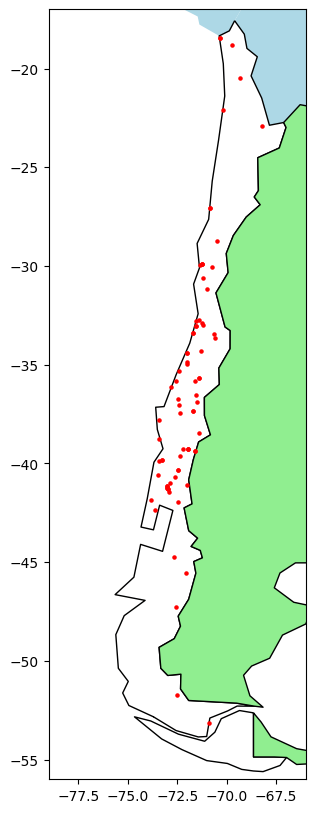

In [65]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargamos los datos geográficos de los países
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Configuración del mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Dibujar el mapa base, Chile y Argentina
world.plot(ax=ax, color='lightblue')  # Océano y otros países
world[world.name == 'Chile'].plot(ax=ax, color='white', edgecolor='black')  # Chile
world[world.name == 'Argentina'].plot(ax=ax, color='lightgreen', edgecolor='black')  # Argentina

# Dibujar los puntos (asegúrate de que 'gdf' esté definido como antes)
gdf.plot(ax=ax, marker='o', color='red', markersize=5)

# Configuración de los límites del mapa
ax.set_xlim(map_bounds['xmin'], map_bounds['xmax'])
ax.set_ylim(map_bounds['ymin'], map_bounds['ymax'])

plt.show()


C:\Users\n3mes\AppData\Local\Temp\ipykernel_28640\3995724584.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


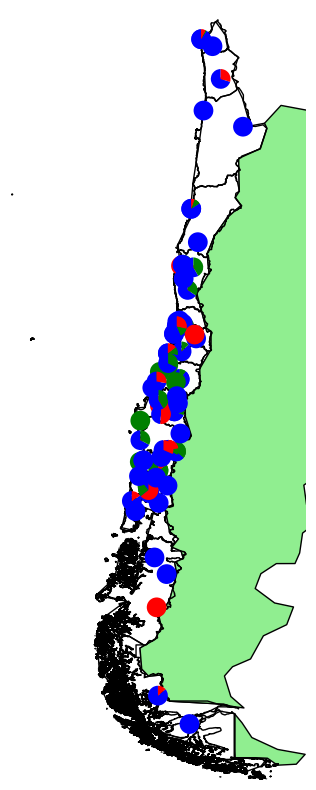

In [66]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Rutas a los archivos shapefile
file_regiones = './REGIONES/REGIONES_v1.shp'  # Reemplaza si es necesario
file_provincias = './PROVINCIAS/PROVINCIAS_v1.shp'  # Reemplaza si es necesario

# Cargamos los datos geográficos
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
regiones_chile = gpd.read_file(file_regiones)
#provincias_chile = gpd.read_file(file_provincias)

# Configuración del mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Dibujar el mapa base, Chile y Argentina
#world.plot(ax=ax, color='lightblue')  # Océano y otros países
world[world.name == 'Chile'].plot(ax=ax, color='white', edgecolor='black')  # Chile
world[world.name == 'Argentina'].plot(ax=ax, color='lightgreen', edgecolor='black')  # Argentina

# Dibujar regiones y provincias de Chile
regiones_chile.plot(ax=ax, edgecolor='black', facecolor='none')  # Regiones

# Dibujar los puntos (asegúrate de que 'gdf' esté definido como antes)
gdf.plot(ax=ax, marker='o', color='red', markersize=5)


# Dibujar los gráficos de pastel en cada punto
for idx, row in gdf.iterrows():
    sizes = [row['VTE'], row['TF'], row['GE']]
    total = sum(sizes)
    if total > 0:  # Evitar división por cero
        sizes = [x / total for x in sizes]  # Normaliza los valores para que sumen 100%
        ax.pie(sizes, center=(row.geometry.x, row.geometry.y), radius=0.5, colors=['blue', 'green', 'red'], startangle=90)

ax.set_xlim([-80, -65])
ax.set_ylim([-56, -17])

plt.show()


C:\Users\n3mes\AppData\Local\Temp\ipykernel_28640\2087075960.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


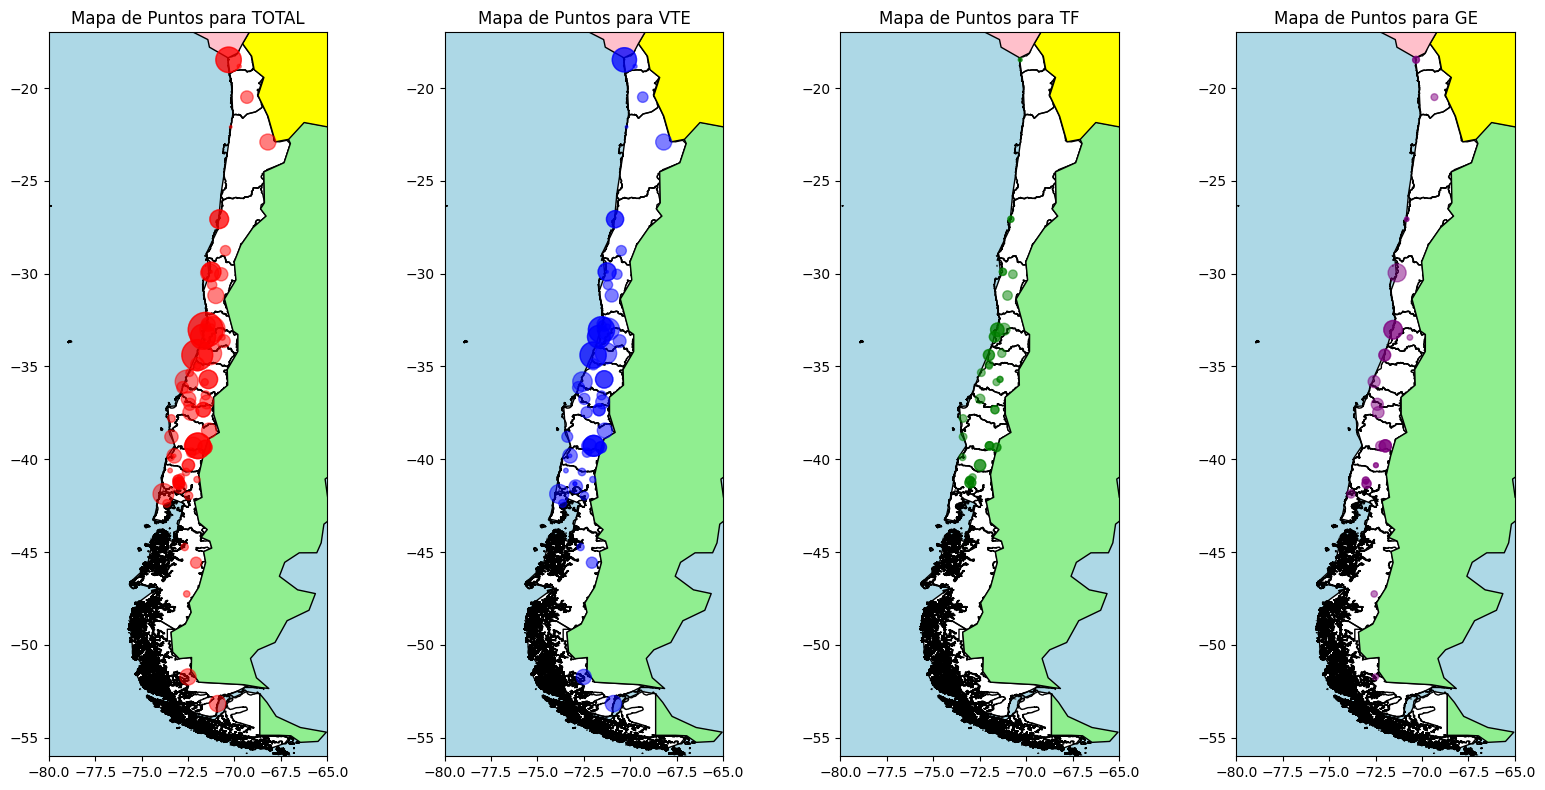

In [73]:
# Creando un grid de subplots con todos los mapas en la misma fila
fig, axs = plt.subplots(1, 4, figsize=(16, 8))  # 4 mapas en una fila

# Cargamos los datos geográficos de los países
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
regiones_chile = gpd.read_file(file_regiones)


# Asegúrate de que 'gdf' esté definido y contenga las columnas necesarias

# Definir un factor de escala para los tamaños de los puntos y colores para cada columna
scale_factor = 0.1
colors = {
    'TOTAL': 'red',
    'VTE': 'blue',
    'TF': 'green',
    'GE': 'purple'
}

# Iterar sobre cada columna y su respectivo eje
for idx, column in enumerate(['TOTAL', 'VTE', 'TF', 'GE']):
    ax = axs[idx]
    ax.set_facecolor('lightblue')  # Pintar el fondo del gráfico de celeste para el océano

    world[world.name == 'Chile'].plot(ax=ax, color='white', edgecolor='black')
    regiones_chile.plot(ax=ax, edgecolor='black', facecolor='none')  # Regiones

    world[world.name == 'Argentina'].plot(ax=ax, color='lightgreen', edgecolor='black')
    world[world.name == 'Bolivia'].plot(ax=ax, color='yellow', edgecolor='black')
    world[world.name == 'Peru'].plot(ax=ax, color='pink', edgecolor='black')
    gdf.plot(ax=ax, 
             marker='o', 
             color=colors[column], 
             markersize=gdf[column] * scale_factor, 
             alpha=0.5)

    ax.set_title(f'Mapa de Puntos para {column}')
    ax.set_xlim([-80, -65])
    ax.set_ylim([-56, -17])

plt.tight_layout()
plt.show()


